In [5]:
import os
import re
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import sys
%matplotlib inline
import pandas as pd
import seaborn as sns
import xgboost as xgb
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from aesthetics import params
mpl.rcParams.update(params)
plt.rcParams.update(params)

In [8]:
# load data
X = pd.read_pickle("../data/application3/user_age_X.pkl")
Y = pd.read_pickle("../data/application3/user_age_Y.pkl")
# select users that has at least 3 labels
index = np.sum(X == 1, axis=1) >=5
X = X[index]
Y = Y[index]

In [21]:
def age_to_labels(age, step=2):
    upper = 50 + step
    bins = np.arange(20, upper, step)
    if age < 20:
        return "20-"
    elif age >= upper - step:
        return "{}+".format(str(upper-step))
    else:
        index = np.argmax((bins - age)>0)
        return "{}-{}".format(bins[index-1], bins[index])
# initialize the groups 
y = Y.gender + Y.age.apply(age_to_labels)
groups, counts = np.unique(y, return_counts=True)
print("There are {} age groups in total".format(groups.shape[0]))
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_ = label_encoder.transform(y)

There are 34 age groups in total


In [58]:
def evaluate_model_cv(X, y, measures, mapping,  
                  params, niter=10, nfold=5, random_state=0):
    """
    Evaluate the measures given a mapping.
    """
    y_dist = compute_y_dist(y)
    skf = StratifiedKFold(n_splits=nfold)
    skf.get_n_splits(X, y)
    K_ = len(mapping.inverse)
    print("K'={}".format(K_))
    params['num_class'] = K_
    res = {measure:[] for measure in measures}
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        data_train = xgb.DMatrix(X_train, mapping.map(y_train))
        data_test = xgb.DMatrix(X_test, mapping.map(y_test))
        watchlist = [(data_train, 'train'), (data_test, 'eval')]
        gbm = xgb.train(params, data_train, niter, evals=watchlist, 
                    verbose_eval=niter)
        y_pred = np.argmax(gbm.predict(data_test), axis=1)
        for measure in measures:
            if measure == "ITCA":
                res[measure].append(measures[measure](y_test, y_pred, mapping, y_dist=y_dist))
            else:
                res[measure].append(measures[measure](mapping.map(y_test), y_pred))
    return res

def greedy_search_cv(X, y, measures, params, 
                     label_encoder, nfold=5, output="cv_check_point.pkl", niter=10):
    n_classes = np.unique(y).shape[0]
    cur_mapping = bidict({i:i for i in range(n_classes)})
    path = {key: [] for key in measures}
    path["mapping"] = []
    # compute current measures
    path["mapping"].append(cur_mapping)
    y_ = label_encoder.transform(y)
    res = evaluate_model_cv(X, y_, measures, 
                     cur_mapping, params, niter=niter, nfold=nfold)
    for measure in measures:
        path[measure].append(res[measure])
    while len(cur_mapping.inverse) > 2:
        # generate next mapping
        acc_l = []
        itca_l = []
        mapping_l = []
        now = datetime.datetime.now()
        print("========={}=============".format(now.strftime("%Y-%m-%d %H:%M:%S")))
        print("Start search....")
        for mapping_k in next_mapping(cur_mapping, label_encoder):
            res = evaluate_model_cv(X, y_, measures, 
                     mapping_k, params, niter=niter, nfold=nfold)
            mapping_l.append(mapping_k)
            acc_l.append(res["ACC"])
            itca_l.append(res["ITCA"])
        idx_max = np.argmax([np.mean(l) for l in itca_l])
        # save the results to path
        path["mapping"].append(mapping_l[idx_max])
        path["ITCA"].append(itca_l[idx_max])
        path["ACC"].append(acc_l[idx_max])
        cur_mapping = mapping_l[idx_max]
        # save results at each iteration
        with open(output, 'wb') as handle:
            check_point = dict()
            check_point["mapping"] = [dict(m) for m in path["mapping"]]
            check_point["ITCA"] = path["ITCA"]
            check_point["ACC"] = path["ACC"]
            pickle.dump(check_point, handle, 
                        protocol=pickle.HIGHEST_PROTOCOL)
        now = datetime.datetime.now()
        print("========={}=============".format(now.strftime("%Y-%m-%d %H:%M:%S")))
        print("Round={}||Write in {}".format(34 - len(cur_mapping.inverse), output))
    return path

In [ ]:
# It takes >20 hours on a destop  
path = greedy_search_cv(X.to_numpy(), y.to_numpy(), measures, 
               params, label_encoder, nfold=5, output="../data/application3/search_cv_check_point", niter=300)

K'=34
[0]	train-merror:0.81596	eval-merror:0.92402
[299]	train-merror:0.20680	eval-merror:0.90195
[0]	train-merror:0.82521	eval-merror:0.91106
[299]	train-merror:0.21433	eval-merror:0.88431
[0]	train-merror:0.82733	eval-merror:0.91000
[299]	train-merror:0.21125	eval-merror:0.87837
[0]	train-merror:0.82844	eval-merror:0.90809
[299]	train-merror:0.21852	eval-merror:0.87391
[0]	train-merror:0.82982	eval-merror:0.91233
[299]	train-merror:0.20860	eval-merror:0.88304
=========2020-12-24 21:22:22=============
Start search....
K'=33
[0]	train-merror:0.82175	eval-merror:0.92551
[299]	train-merror:0.21153	eval-merror:0.89537
[0]	train-merror:0.82404	eval-merror:0.90490
[299]	train-merror:0.21841	eval-merror:0.87604
[0]	train-merror:0.82388	eval-merror:0.90724
[299]	train-merror:0.21470	eval-merror:0.87922
[0]	train-merror:0.82452	eval-merror:0.90405
[299]	train-merror:0.21926	eval-merror:0.87179
[0]	train-merror:0.82468	eval-merror:0.90405
[299]	train-merror:0.21194	eval-merror:0.88049
K'=33
[0]

##  Figure 8: Results on TalkingData mobile user demographics dataset using XGBoost. 

In [20]:
mapping = bidict(check_point["mapping"][-5])
for key in mapping.inverse:
    age_group = label_encoder.inverse_transform(mapping.inverse[key])
    print(age_group)
    
with open('../data/application3/search_cv_check_point', 'rb') as handle:
    check_point = pickle.load(handle)
itca_mean = np.array([ np.mean(l) for l in check_point["ITCA"]])
itca_std = np.array([ np.std(l) for l in check_point["ITCA"]])
acc_mean = np.array([np.mean(l) for l in check_point["ACC"]])
acc_std = np.array([np.std(l) for l in check_point["ACC"]])
ind_max = np.argmax(itca_mean)

['F20-' 'F20-22' 'F22-24']
['F24-26' 'F26-28' 'F28-30' 'F30-32' 'F32-34' 'F34-36' 'F36-38' 'F38-40']
['F40-42' 'F42-44' 'F44-46' 'F46-48' 'F48-50' 'F50+']
['M20-' 'M20-22' 'M22-24' 'M24-26']
['M26-28' 'M28-30' 'M30-32' 'M32-34']
['M34-36' 'M36-38' 'M38-40' 'M40-42' 'M42-44' 'M44-46' 'M46-48' 'M48-50'
 'M50+']


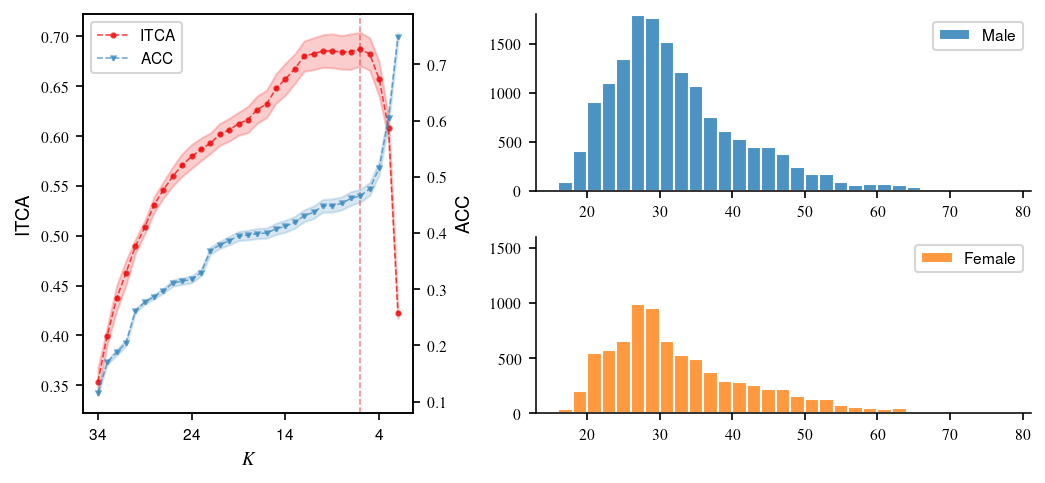

In [25]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 3])
figure = plt.figure()
ax = plt.subplot(gs[:, 0 ]) # row 0, col 0
curve1, = ax.plot(itca_mean, label="ITCA", color="#F20708", 
        marker="o", linestyle="--", alpha=0.75)
factor = 1 / np.sqrt(5)
ax.fill_between(np.arange(itca_mean.size), itca_mean - itca_std * factor, itca_mean + itca_std * factor,
                alpha=0.2, color="#F20708")
ax2 = ax.twinx() 
curve2, = ax2.plot(acc_mean, label="ACC", color="#3C8ABE",
        marker="v", linestyle="--", alpha=0.75)
ax2.fill_between(np.arange(acc_mean.size), acc_mean - acc_std * factor, acc_mean + acc_std * factor,
                alpha=0.2, color="#3C8ABE")
curves = [curve1, curve2]
ax.axvline(x=ind_max, linestyle="--", color="#F20708", alpha=0.5)
ax2.set_xticks([0, 10, 20, 30])
ax2.set_xticklabels([34, 24, 14, 4])
ax.set_xlabel("$K$")
ax2.set_ylabel("ACC")
ax.set_ylabel("ITCA")
ax.legend(curves, [curve.get_label() for curve in curves])
ax3 = plt.subplot(gs[0, 1])
ax3.hist(age_male, np.arange(16, 80, 2), edgecolor='white', color="#4C92C3", label="Male")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# ax3.set_title("Male")
ax3.set_ylim([0, 1800])
ax3.legend()
# 
ax4 = plt.subplot(gs[1, 1])
ax4.hist(age_female, np.arange(16, 80, 2), edgecolor='white', color="#FF983E", label="Female")
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax4.set_title("Female")
ax4.legend()
ax4.set_ylim([0, 1600])
figure.set_size_inches(7, 3.25)
plt.tight_layout()